# コードリーディング

## 【問題1】スクラッチを振り返る

- バッチサイズを決める
- 学習率、エポック数を決める
- 重み、バイアスの初期値を決める
- フォワードプロパゲーション
- 交差エントロピー誤差を求める
- バックプロパゲーション
- 学習と推定をする
- Accuracyを求める

### データセットの用意


## 【問題2】スクラッチとTensorFlowの対応を考える

In [93]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

#####ここまでがexample_net関数##########


# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 0.0001, val_loss : 4.3731, acc : 1.000, val_acc : 0.750
Epoch 1, loss : 0.0000, val_loss : 2.7000, acc : 1.000, val_acc : 0.875
Epoch 2, loss : 0.0000, val_loss : 3.8944, acc : 1.000, val_acc : 0.750
Epoch 3, loss : 2.3992, val_loss : 10.9669, acc : 0.750, val_acc : 0.750
Epoch 4, loss : 2.1050, val_loss : 13.2431, acc : 0.750, val_acc : 0.500
Epoch 5, loss : 4.5652, val_loss : 12.7972, acc : 0.500, val_acc : 0.625
Epoch 6, loss : 7.2154, val_loss : 23.4532, acc : 0.750, val_acc : 0.438
Epoch 7, loss : 0.4274, val_loss : 9.1010, acc : 0.750, val_acc : 0.750
Epoch 8, loss : 0.0001, val_loss : 7.2473, acc : 1.000, val_acc : 0.625
Epoch 9, loss : 0.0000, val_loss : 2.2133, acc : 1.000, val_acc : 0.875
test_acc : 0.850


# 他のデータセットへの適用


## 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

In [53]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを3値分類する
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt


In [54]:
# データセットの読み込み
dataset_path ="Iris.csv"
df3 = pd.read_csv(dataset_path)


In [55]:
# データフレームから条件抽出
df3 = df3[(df3["Species"] == "Iris-versicolor")|(df3["Species"] == "Iris-virginica")|(df3["Species"] == "Iris-setosa")]
y = df3["Species"]
X = df3.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test3, y_train, y_test3 = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [95]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot3 = enc.fit_transform(y_train3)#[:, np.newaxis])
y_test_one_hot3 = enc.transform(y_test3)#[:, np.newaxis])

print(y_train3.shape) # (60000,)
print(y_train_one_hot3.shape) # (60000, 10)
print(y_train_one_hot3.dtype) # float64

(96, 1)
(96, 3)
float64


In [76]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train3.shape[1]
n_samples = X_train3.shape[0]
n_classes = 3

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train3, y_train_one_hot3, batch_size=batch_size)

def NN(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output



In [77]:
# ネットワーク構造の読み込み                               
logits = NN(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(tf.nn.softmax(logits), 1))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train3.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        #val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val3, Y: y_val3})
        #print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        print("Epoch {}, loss : {:.4f}, acc : {:.3f}".format(epoch, loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test3, Y: y_test_one_hot3})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 52.5810, acc : 0.333
Epoch 1, loss : 0.6571, acc : 0.833
Epoch 2, loss : 0.0000, acc : 1.000
Epoch 3, loss : 0.7619, acc : 0.833
Epoch 4, loss : 0.0000, acc : 1.000
Epoch 5, loss : 0.0007, acc : 1.000
Epoch 6, loss : 0.0000, acc : 1.000
Epoch 7, loss : 0.0000, acc : 1.000
Epoch 8, loss : 0.0225, acc : 1.000
Epoch 9, loss : 0.0000, acc : 1.000
test_acc : 1.000


## 【問題4】House Pricesのモデルを作成


In [8]:
# データセットの読み込み
dataset_path2 ="train.csv"
df2 = pd.read_csv(dataset_path2)

In [9]:
# データセットの読み込み
dataset_path2 ="train.csv"
df2 = pd.read_csv(dataset_path2)
# データフレームから条件抽出
y = df2["SalePrice"]
X = df2.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)

# trainとtestに分割
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=0)



In [10]:
SSx = StandardScaler()
SSx.fit(X_train2)
X_transform = SSx.transform(X_train2)

SSy = StandardScaler()
SSy.fit(y_train2.reshape(-1,1))
y_transform = SSy.transform(y_train2.reshape(-1,1)).reshape(-1)

/Users/takamoriyuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
n_features = X_train2.shape[1]
n_samples = X_train2.shape[0]

#プレースホルダーを定義
X = tf.placeholder("float", [n_samples, n_features])
Y = tf.placeholder("float", [n_samples,])

#変数（モデルのパラメータ）を定義
W = tf.Variable(tf.random_normal([n_features,1]))
B = tf.Variable(tf.random_normal([1]))

#モデルを構築
y_hat = tf.add(tf.matmul(X, W), B)

#コストを計算
cost = tf.reduce_mean(tf.square(y_hat - Y)) / 2

#最急降下法
optim = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train_op = optim.minimize(cost)

In [12]:
n_epochs = 100
training_costs = []

# variableの初期化
init = tf.global_variables_initializer()

with tf.Session() as sess:
    #変数を初期化
    sess.run(init)
    
    #学習
    for e in range(n_epochs):
        c, _ = sess.run([cost, train_op], feed_dict={X:X_transform, Y:y_transform})
        
        training_costs.append(c)
    
    

In [13]:
training_costs

[0.9396572,
 0.9388147,
 0.9379739,
 0.9371347,
 0.93629724,
 0.9354613,
 0.9346269,
 0.93379426,
 0.93296313,
 0.9321336,
 0.9313058,
 0.9304796,
 0.92965496,
 0.92883193,
 0.9280105,
 0.92719066,
 0.92637235,
 0.92555577,
 0.9247407,
 0.9239271,
 0.9231152,
 0.92230487,
 0.9214962,
 0.92068905,
 0.91988343,
 0.9190794,
 0.9182769,
 0.91747594,
 0.91667664,
 0.9158789,
 0.91508263,
 0.914288,
 0.91349477,
 0.91270316,
 0.911913,
 0.91112447,
 0.9103375,
 0.909552,
 0.90876806,
 0.9079857,
 0.90720475,
 0.9064254,
 0.90564746,
 0.90487105,
 0.9040962,
 0.9033229,
 0.90255094,
 0.90178066,
 0.90101177,
 0.9002444,
 0.89947855,
 0.8987142,
 0.8979512,
 0.8971899,
 0.8964299,
 0.8956715,
 0.89491445,
 0.89415896,
 0.89340484,
 0.8926522,
 0.8919011,
 0.89115137,
 0.8904032,
 0.8896564,
 0.8889112,
 0.8881674,
 0.8874248,
 0.8866839,
 0.88594437,
 0.8852063,
 0.8844696,
 0.88373435,
 0.88300055,
 0.88226813,
 0.8815372,
 0.8808075,
 0.8800795,
 0.87935275,
 0.87862736,
 0.87790346,
 0.8771

<function matplotlib.pyplot.show(*args, **kw)>

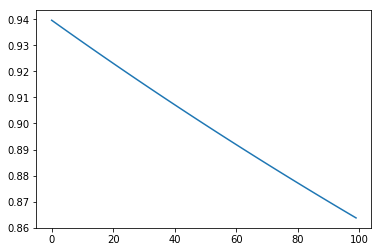

In [14]:
plt.plot(training_costs)
plt.show

## 【問題5】MNISTのモデルを作成

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()



X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## 前処理

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [91]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 20
num_epochs = 10

n_hidden1 = 400
n_hidden2 = 200
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def NN(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output



In [92]:
# ネットワーク構造の読み込み                               
logits = NN(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(tf.nn.softmax(logits), 1))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        #val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val3, Y: y_val3})
        #print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        print("Epoch {}, loss : {:.4f}, acc : {:.3f}".format(epoch, loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 0.4615, acc : 0.850
Epoch 1, loss : 0.5730, acc : 0.800
Epoch 2, loss : 0.9227, acc : 0.700
Epoch 3, loss : 1.1090, acc : 0.650
Epoch 4, loss : 0.5164, acc : 0.800
Epoch 5, loss : 0.4055, acc : 0.900
Epoch 6, loss : 0.3872, acc : 0.900
Epoch 7, loss : 0.3316, acc : 0.900
Epoch 8, loss : 0.3682, acc : 0.900
Epoch 9, loss : 0.3595, acc : 0.900
test_acc : 0.850
